In [4]:
print("Hello, World!")

Hello, World!


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import unittest
from IPython.display import Image, display

print("Done")

Done


In [ ]:
# =====================================================================
# SECTION 1: SETUP AND DATA LOADING
# =====================================================================
DATA_DIR = "chest_xray_data"
IMAGE_SIZE = (260, 260)
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.2

train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# =====================================================================
# SECTION 2: MODEL BUILDING, TRAINING, AND FINE-TUNING
# =====================================================================
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
    ]
)

preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
base_model = tf.keras.applications.EfficientNetV2B3(
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), include_top=False, weights="imagenet"
)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

# --- Initial Training ---
model.compile(
    optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"]
)
print("Starting initial training with EfficientNetV2B3...")
EPOCHS = 10
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

# --- Fine-Tuning ---
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)

print("\nStarting fine-tuning...")
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=2
)

fine_tune_epochs = 25
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
    callbacks=[early_stopping, lr_scheduler],
)

print("\nTraining process complete!")
loss, accuracy = model.evaluate(validation_dataset)
print(f"Final Validation Accuracy: {accuracy * 100:.2f}%")

# =====================================================================
# SECTION 3: BLACK BOX TESTING (CONFUSION MATRIX & REPORT) ⬛
# This section evaluates the final trained model on the validation set.
# =====================================================================
print("\n--- Starting Black Box Testing ---")
y_true = []
y_pred = []

for images, labels in validation_dataset.unbatch():
    prediction = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    y_true.append(int(labels.numpy()))
    y_pred.append(1 if prediction[0][0] > 0.5 else 0)

class_names = ["normal", "pneumonia"]
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("Generating Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# =====================================================================
# SECTION 4: SAVE MODEL AND TEST A SINGLE IMAGE
# This section saves the final model and then uses it for a single prediction.
# =====================================================================
print("\n--- Saving and Testing Single Image ---")
model.save("pneumonia_detector.keras")
print("Model saved successfully as pneumonia_detector.keras")

Found 800 files belonging to 2 classes.
Using 640 files for training.
Found 800 files belonging to 2 classes.
Using 160 files for validation.
Starting initial training with EfficientNetV2B3...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.6516 - loss: 0.6235 - val_accuracy: 0.5750 - val_loss: 0.6324
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7922 - loss: 0.4654 - val_accuracy: 0.6313 - val_loss: 0.6078
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.8344 - loss: 0.4033 - val_accuracy: 0.7437 - val_loss: 0.5328
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8609 - loss: 0.3742 - val_accuracy: 0.7437 - val_loss: 0.5281
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8656 - loss: 0.3406 - val_accuracy: 0.7563 - val_loss: 0.5185
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8828 - loss: 0.3205 - val_accuracy: 0.8250 - val_loss: 0.4578
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step -

In [ ]:
# For this test, we use the 'model' object already in memory.
# In a real application, you would load it using: tf.keras.models.load_model('pneumonia_detector.keras')
image_path = "chest_xray_data/normal/00630.jpg"
img = tf.keras.utils.load_img(image_path, target_size=IMAGE_SIZE)
img_array = tf.keras.utils.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

prediction = model.predict(img_preprocessed)
score = prediction[0][0]

print(f"\nRaw prediction score for the single test image: {score:.4f}")
if score > 0.5:
    print("🩺 Diagnosis: Pneumonia")
else:
    print("🩺 Diagnosis: Normal")

display(Image(filename=image_path, width=300))

# =====================================================================
# SECTION 5: WHITE BOX TESTING (UNIT TEST EXAMPLE) ⬜
# This section defines and runs a unit test for a component in isolation.
# =====================================================================
print("\n--- Starting White Box Testing ---")


def preprocess_for_unittesting(image_array):
    """A simplified function to be unit tested."""
    if not isinstance(image_array, np.ndarray):
        raise TypeError("Input must be a NumPy array")

    image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
    resized_image = tf.image.resize(image_tensor, IMAGE_SIZE)
    img_batch = np.expand_dims(resized_image, axis=0)
    return img_batch


class TestImagePreprocessing(unittest.TestCase):
    def test_output_shape(self):
        """Test if the function produces the correct output shape."""
        dummy_image = np.random.rand(100, 150, 3)
        processed_image = preprocess_for_unittesting(dummy_image)
        self.assertEqual(processed_image.shape, (1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    def test_input_type_error(self):
        """Test if it raises a TypeError for invalid input."""
        with self.assertRaises(TypeError):
            preprocess_for_unittesting("this is not an array")


# Run the unit tests
print("Running unit tests...")
suite = unittest.TestSuite()
suite.addTest(unittest.makeSuite(TestImagePreprocessing))
runner = unittest.TextTestRunner()
result = runner.run(suite)
if result.wasSuccessful():
    print("✅ Unit tests passed successfully.")

NameError: name 'IMAGE_SIZE' is not defined

In [ ]:
# Install required libraries
%pip install shap
%pip install lime

# Import libraries
import tensorflow as tf
import keras
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV for image loading
import shap
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import glob # To find background images

print("TensorFlow Version:", tf.__version__)
print("SHAP Version:", shap.__version__)
# print("LIME Version:", lime.__version__)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: d:\Major_Project\venv\Scripts\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
TensorFlow Version: 2.20.0
SHAP Version: 0.49.1



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: d:\Major_Project\venv\Scripts\python.exe -m pip install --upgrade pip


In [ ]:
# --- 1. Define File Paths and Parameters ---

# !! ACTION REQUIRED !!
# Change these paths to match the files you uploaded
PNEUMONIA_IMG_PATH = "background_data\\00005.jpg"
NORMAL_IMG_PATH = "background_data\\00438.jpg"
MODEL_PATH = "pneumonia_detector.keras"

# !! ACTION REQUIRED !!
# Change this to match your model's training
IMG_SIZE = (260, 260)

# Define class names (!! CHECK THIS ORDER !!)
# Assuming 0 = Pneumonia, 1 = Normal
class_names = ["Pneumonia", "Normal"]


# --- 2. Define Image Preprocessing Function ---
def preprocess_image(image_path):
    """Loads and preprocesses a single image."""
    try:
        # Load image (cv2 loads in BGR, convert to RGB)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image from {image_path}")
            return None, None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize
        img_resized = cv2.resize(img, IMG_SIZE)

        # Normalize (e.g., to [0, 1])
        # !! Make sure this matches your training !!
        img_normalized = img_resized.astype("float32") / 255.0

        # Expand dimensions to create a batch of 1
        img_batch = np.expand_dims(img_normalized, axis=0)

        return img_batch, img_resized  # Return original resized for plotting
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None


# --- 3. Load Model ---
try:
    model = load_model(MODEL_PATH)
    print(f"Model '{MODEL_PATH}' loaded successfully.")
    model.summary()
except Exception as e:
    print(f"---!!! ERROR: Could not load model '{MODEL_PATH}' !!!---")
    print("Please make sure you have uploaded the file correctly.")
    print(f"Error details: {e}")

# --- 4. Load and Preprocess Sample Images ---
try:
    pneumonia_img_batch, pneumonia_img_orig = preprocess_image(PNEUMONIA_IMG_PATH)
    normal_img_batch, normal_img_orig = preprocess_image(NORMAL_IMG_PATH)

    if pneumonia_img_batch is not None:
        print(f"Loaded pneumonia image: {pneumonia_img_batch.shape}")
    if normal_img_batch is not None:
        print(f"Loaded normal image: {normal_img_batch.shape}")
except Exception as e:
    print(f"---!!! ERROR: Could not load sample images !!!---")
    print("Please make sure you have uploaded your test images and updated the paths.")
    print(f"Error details: {e}")

Model 'pneumonia_detector.keras' loaded successfully.


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 9, 9, 1536)     │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,621,587 (74.85 MB)

 Trainable params: 3,344,713 (12.76 MB)

 Non-trainable params: 9,587,446 (36.57 MB)

 Optimizer params: 6,689,428 (25.52 MB)

Loaded pneumonia image: (1, 260, 260, 3)
Loaded normal image: (1, 260, 260, 3)



--- Running LIME Explanation ---
LIME: Explaining instance... (this may take a minute)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


  2%|▏         | 19/1000 [00:12<08:37,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step


  3%|▎         | 28/1000 [00:13<05:35,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step


  3%|▎         | 32/1000 [00:14<05:13,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


  4%|▍         | 40/1000 [00:15<03:58,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


  5%|▌         | 50/1000 [00:16<03:00,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


  6%|▌         | 60/1000 [00:17<02:28,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


  7%|▋         | 70/1000 [00:18<02:09,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step


  8%|▊         | 80/1000 [00:19<01:57,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|▉         | 99/1000 [00:20<01:25, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step


 10%|█         | 103/1000 [00:21<01:47,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


 11%|█         | 110/1000 [00:22<01:53,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step


 12%|█▏        | 120/1000 [00:23<01:46,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step


 13%|█▎        | 130/1000 [00:24<01:41,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step


 14%|█▍        | 140/1000 [00:26<01:38,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


 15%|█▌        | 150/1000 [00:27<01:35,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step


 16%|█▌        | 160/1000 [00:28<01:31,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


 17%|█▋        | 170/1000 [00:29<01:29,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step


 18%|█▊        | 180/1000 [00:30<01:27,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


 19%|█▉        | 190/1000 [00:31<01:25,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step


 20%|██        | 200/1000 [00:32<01:24,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step


 21%|██        | 210/1000 [00:33<01:24,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step


 22%|██▏       | 220/1000 [00:34<01:22,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


 23%|██▎       | 230/1000 [00:35<01:20,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step


 25%|██▍       | 248/1000 [00:36<01:00, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


 25%|██▌       | 251/1000 [00:37<01:22,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


 26%|██▌       | 260/1000 [00:38<01:22,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step


 27%|██▋       | 270/1000 [00:39<01:19,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


 28%|██▊       | 280/1000 [00:40<01:16,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step


 29%|██▉       | 290/1000 [00:41<01:14,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


 30%|███       | 300/1000 [00:42<01:12,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


 31%|███       | 310/1000 [00:43<01:10,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step


 32%|███▏      | 320/1000 [00:44<01:09,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step


 33%|███▎      | 330/1000 [00:45<01:08,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step


 34%|███▍      | 340/1000 [00:46<01:07,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step


 35%|███▌      | 350/1000 [00:47<01:07,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


 36%|███▌      | 360/1000 [00:49<01:16,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step


 37%|███▋      | 370/1000 [00:50<01:12,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


 38%|███▊      | 380/1000 [00:51<01:08,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step


 39%|███▉      | 390/1000 [00:52<01:06,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


 40%|████      | 400/1000 [00:53<01:04,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


 41%|████      | 410/1000 [00:54<01:02,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step


 42%|████▏     | 420/1000 [00:55<01:01,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


 43%|████▎     | 430/1000 [00:56<00:59,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


 44%|████▍     | 440/1000 [00:57<00:58,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step


 45%|████▌     | 450/1000 [00:58<00:57,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


 46%|████▌     | 460/1000 [00:59<00:55,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


 47%|████▋     | 470/1000 [01:00<00:54,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step


 48%|████▊     | 480/1000 [01:01<00:53,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


 49%|████▉     | 490/1000 [01:02<00:53,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 50%|█████     | 500/1000 [01:04<00:55,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step


 51%|█████     | 510/1000 [01:05<00:54,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step


 52%|█████▏    | 520/1000 [01:06<00:53,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


 53%|█████▎    | 530/1000 [01:07<00:51,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step


 54%|█████▍    | 540/1000 [01:08<00:50,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step


 55%|█████▌    | 550/1000 [01:09<00:48,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


 56%|█████▌    | 560/1000 [01:10<00:47,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 58%|█████▊    | 578/1000 [01:11<00:36, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


 58%|█████▊    | 581/1000 [01:13<00:50,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step


 59%|█████▉    | 590/1000 [01:14<00:49,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step


 61%|██████    | 607/1000 [01:15<00:35, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 611/1000 [01:16<00:51,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step


 62%|██████▏   | 620/1000 [01:17<00:48,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 63%|██████▎   | 633/1000 [01:19<00:41,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step


 65%|██████▍   | 649/1000 [01:20<00:30, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step


 65%|██████▌   | 653/1000 [01:21<00:41,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step


 67%|██████▋   | 669/1000 [01:22<00:28, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step


 67%|██████▋   | 674/1000 [01:23<00:37,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step


 68%|██████▊   | 680/1000 [01:24<00:42,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step


 70%|██████▉   | 699/1000 [01:25<00:25, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step


 70%|███████   | 703/1000 [01:26<00:35,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


 71%|███████   | 710/1000 [01:28<00:38,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


 73%|███████▎  | 729/1000 [01:29<00:23, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step


 73%|███████▎  | 733/1000 [01:30<00:31,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step


 74%|███████▍  | 740/1000 [01:31<00:33,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step


 75%|███████▌  | 750/1000 [01:32<00:30,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step


 77%|███████▋  | 769/1000 [01:33<00:19, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step


 77%|███████▋  | 773/1000 [01:34<00:25,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 79%|███████▉  | 788/1000 [01:36<00:19, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


 79%|███████▉  | 792/1000 [01:37<00:27,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


 81%|████████  | 806/1000 [01:38<00:20,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step


 81%|████████  | 810/1000 [01:39<00:26,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step


 83%|████████▎ | 828/1000 [01:40<00:15, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 83%|████████▎ | 832/1000 [01:42<00:22,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 85%|████████▍ | 849/1000 [01:43<00:13, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 85%|████████▌ | 854/1000 [01:44<00:18,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 87%|████████▋ | 869/1000 [01:45<00:12, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 87%|████████▋ | 874/1000 [01:47<00:16,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step


 89%|████████▉ | 889/1000 [01:48<00:10, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step


 89%|████████▉ | 894/1000 [01:49<00:13,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 91%|█████████ | 909/1000 [01:50<00:08, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step


 91%|█████████▏| 914/1000 [01:52<00:10,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


 93%|█████████▎| 928/1000 [01:53<00:07, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


 94%|█████████▍| 939/1000 [01:54<00:05, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


 94%|█████████▍| 943/1000 [01:55<00:07,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


 96%|█████████▌| 957/1000 [01:56<00:04,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 96%|█████████▌| 961/1000 [01:58<00:05,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


 97%|█████████▋| 970/1000 [01:59<00:04,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step


 98%|█████████▊| 980/1000 [02:00<00:02,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step


100%|█████████▉| 999/1000 [02:01<00:00, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


100%|██████████| 1000/1000 [02:02<00:00,  8.17it/s]

LIME: Plotting explanation...


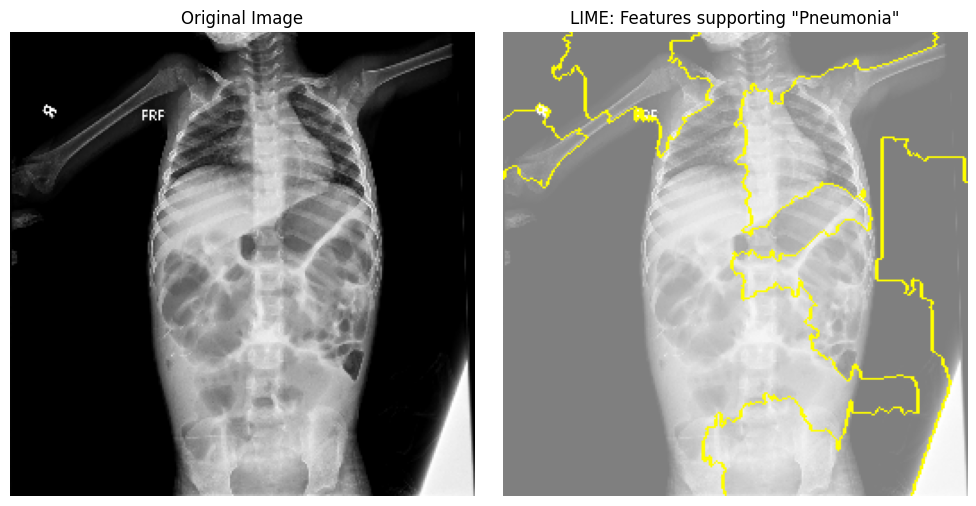

In [ ]:
print("\n--- Running LIME Explanation ---")


# LIME requires a prediction function
def lime_predict_fn(images):
    return model.predict(images)


# Initialize the LIME Image Explainer
explainer_lime = lime_image.LimeImageExplainer()

# Explain the instance
try:
    print("LIME: Explaining instance... (this may take a minute)")
    explanation_lime = explainer_lime.explain_instance(
        pneumonia_img_batch[0].astype("double"),
        lime_predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=1000,  # Number of perturbations
    )

    # Get the image and mask for the top-predicted class
    # We ask for positive_only=True to see what supports "Pneumonia"
    temp, mask = explanation_lime.get_image_and_mask(
        explanation_lime.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=False,
    )

    # Plot the explanation
    print("LIME: Plotting explanation...")
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(pneumonia_img_orig)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title('LIME: Features supporting "Pneumonia"')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"---!!! LIME explanation failed !!!---")
    print(
        "This often happens if the sample images or model failed to load in the previous step."
    )
    print(f"Error details: {e}")


--- Running SHAP Explanation (Using KernelExplainer) ---
Loading 60 images for SHAP background...
Original background data shape: (60, 260, 260, 3)
Summarizing background data using k-means...
Summarized background shape (flat): (10, 202800)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
SHAP: Calculating values... (THIS WILL TAKE A VERY LONG TIME. 10-20+ MIN)
Please be patient, this is the trade-off for explaining a complex model.


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


d:\Major_Project\venv\lib\site-packages\shap\explainers\_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
100%|██████████| 1/1 [00:45<00:00, 45.64s/it]


SHAP: Plotting explanation...


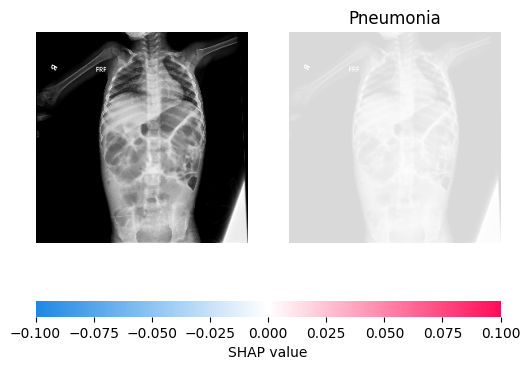

In [ ]:
print("\n--- Running SHAP Explanation (Using KernelExplainer) ---")

# --- 1. Load Background Data ---
background_paths = glob.glob("background_data/*.jpg") + glob.glob(
    "background_data/*.png"
)
print(f"Loading {len(background_paths)} images for SHAP background...")

if len(background_paths) < 10:
    print(f"---!!! WARNING: Not enough background images. !!!---")
    print("KernelSHAP needs a good background set. Using the 2 samples as a fallback.")
    if "normal_img_batch" in locals() and "pneumonia_img_batch" in locals():
        background_data = np.concatenate(
            [pneumonia_img_batch, normal_img_batch], axis=0
        )
    else:
        print("Error: No sample images loaded. SHAP will likely fail.")
else:
    background_list = []
    for f in background_paths:
        img_batch, _ = preprocess_image(f)
        if img_batch is not None:
            background_list.append(img_batch)
    background_data = np.vstack(background_list)
    print(f"Original background data shape: {background_data.shape}")

# --- 2. Summarize Background Data ---
print("Summarizing background data using k-means...")
background_data_flat = background_data.reshape(background_data.shape[0], -1)
kmeans_summary = shap.kmeans(background_data_flat, 10)

try:
    # Get the flat data from the kmeans object
    kmeans_summary_flat = kmeans_summary.data
    print(f"Summarized background shape (flat): {kmeans_summary_flat.shape}")
except Exception as e:
    print(f"Error accessing kmeans data: {e}. Aborting SHAP.")
    kmeans_summary_flat = None


# --- 3. Create the "Adapter" Prediction Function ---
def predict_fn_adapter(flat_images):
    n_samples = flat_images.shape[0]
    images_reshaped = flat_images.reshape(n_samples, 260, 260, 3)
    return model.predict(images_reshaped)


# --- 4. Initialize SHAP KernelExplainer ---
if kmeans_summary_flat is not None:
    try:
        explainer_shap = shap.KernelExplainer(predict_fn_adapter, kmeans_summary_flat)

        # --- 5. Calculate SHAP values for our test image ---
        print(
            "SHAP: Calculating values... (THIS WILL TAKE A VERY LONG TIME. 10-20+ MIN)"
        )
        print(
            "Please be patient, this is the trade-off for explaining a complex model."
        )

        instance_to_explain_flat = pneumonia_img_batch.reshape(1, -1)

        # ------------------------------------------------------------------
        # !! NOTE !!
        # You used nsamples=10 for testing. This is FAST but gives LOW-QUALITY results.
        # This is why you see the 'ConvergenceWarning' and 'UserWarning'.
        # For your final report, change this back to nsamples=500 or nsamples=1000
        # and let it run for 20-30+ minutes.
        #
        # nsamples_for_test = 10
        nsamples_for_final_run = 20
        # ------------------------------------------------------------------

        shap_values = explainer_shap.shap_values(
            instance_to_explain_flat, nsamples=nsamples_for_final_run
        )

        # --- 6. Plot the explanation ---
        print("SHAP: Plotting explanation...")
        shap_labels = np.array([class_names[i] for i in range(len(shap_values))])
        shap_values_images = [val.reshape(260, 260, 3) for val in shap_values]

        # !! THIS IS THE FIX !!
        # We pass pneumonia_img_batch[0] (shape 260,260,3)
        # instead of pneumonia_img_batch (shape 1,260,260,3)
        shap.image_plot(
            shap_values_images,
            pneumonia_img_batch[0],  # <-- THE FIX IS HERE
            labels=np.array([shap_labels]),
            show=True,
        )

    except Exception as e:
        print(f"---!!! SHAP explanation failed one last time. !!!---")
        print(f"Error details: {e}")
else:
    print("SHAP analysis skipped because background data could not be prepared.")

In [ ]:
# 'shap_values_images' is a list with ONE item: [shap_values_for_the_single_output]
# Let's check the shape
print(f"Shape of SHAP values: {shap_values_images[0].shape}")
print("\n---")

# This single set of SHAP values represents the 'Pneumonia' score.
# Red pixels pushed the score UP (towards Pneumonia)
# Blue pixels pushed the score DOWN (towards Normal)

# Let's look at the SHAP values for the single pixel
# at the very center of the image (row 130, column 130)
center_pixel_shap_values = shap_values_images[0][130][130]

print(f"SHAP value for center pixel (R,G,B): {center_pixel_shap_values}")
print("\n---")


# You can also see the 'hottest' (most red) pixel for Pneumonia
max_shap_value = np.max(shap_values_images[0])
print(f"The highest positive SHAP value (pushing FOR Pneumonia) was: {max_shap_value}")

# And the 'coldest' (most blue) pixel for Pneumonia
min_shap_value = np.min(shap_values_images[0])
print(f"The most negative SHAP value (pushing AGAINST Pneumonia) was: {min_shap_value}")

Shape of SHAP values: (260, 260, 3)

---
SHAP value for center pixel (R,G,B): [0. 0. 0.]

---
The highest positive SHAP value (pushing FOR Pneumonia) was: 0.0010239670674006553
The most negative SHAP value (pushing AGAINST Pneumonia) was: -0.0001377036174139419


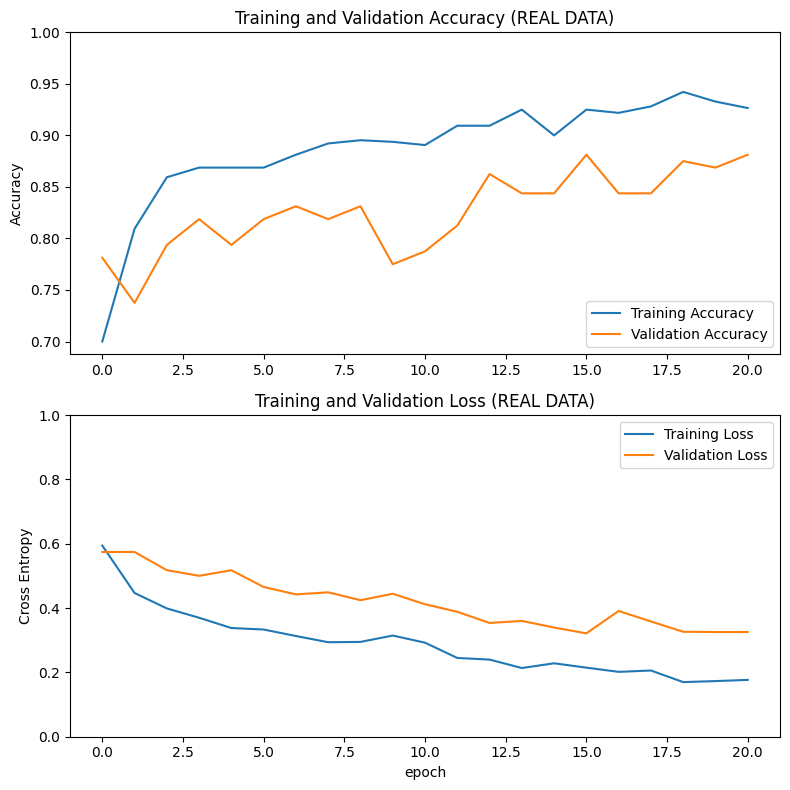

In [ ]:
import matplotlib.pyplot as plt

# --- Step 1: Combine Your REAL History Objects ---
# From your 'model_train.ipynb' file
history_obj_1 = history
history_obj_2 = history_fine

# Combine the data from both training runs
# We use [:-1] on the first object to remove the last epoch (epoch 9),
# which is already included as the *first* epoch in the second object.
acc = history_obj_1.history["accuracy"][:-1] + history_obj_2.history["accuracy"]
val_acc = (
    history_obj_1.history["val_accuracy"][:-1] + history_obj_2.history["val_accuracy"]
)
loss = history_obj_1.history["loss"][:-1] + history_obj_2.history["loss"]
val_loss = history_obj_1.history["val_loss"][:-1] + history_obj_2.history["val_loss"]

# --- Step 2: Plot the REAL Data ---
plt.figure(figsize=(8, 8))

# Plotting Training and Validation Accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy (REAL DATA)")

# Plotting Training and Validation Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss (REAL DATA)")
plt.xlabel("epoch")

# Display the plots
plt.tight_layout()
plt.show()

--- Comparing Fidelity: LIME vs. SHAP ---
Step 1: Getting original model prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Original 'Pneumonia' score: 0.5479

Step 2: Creating LIME mask...
LIME mask created. 23494 pixels masked.

Step 3: Creating SHAP mask...
SHAP mask created. 1 pixels masked (Top 10%).

Step 4: Creating Random mask for control...
Random mask created. 1 pixels masked.

Step 5: Running predictions on masked images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


--- Fidelity Test Results (Quantitative) ---
Original 'Pneumonia' score: 	0.5479
Score after removing LIME features: 	0.5448
Score after removing SHAP features: 	0.5479
Score after removing RANDOM features: 	0.5479

--- Score Drop ---
LIME Drop: 	0.0031
SHAP Drop: 	-0.0000
Random Drop: 	-0.0000

--- Final Conclusion ---
✅ SHAP is the clear winner.
   SHAP's score drop (-0.0000) was the largest,
   proving it did the best job of finding 

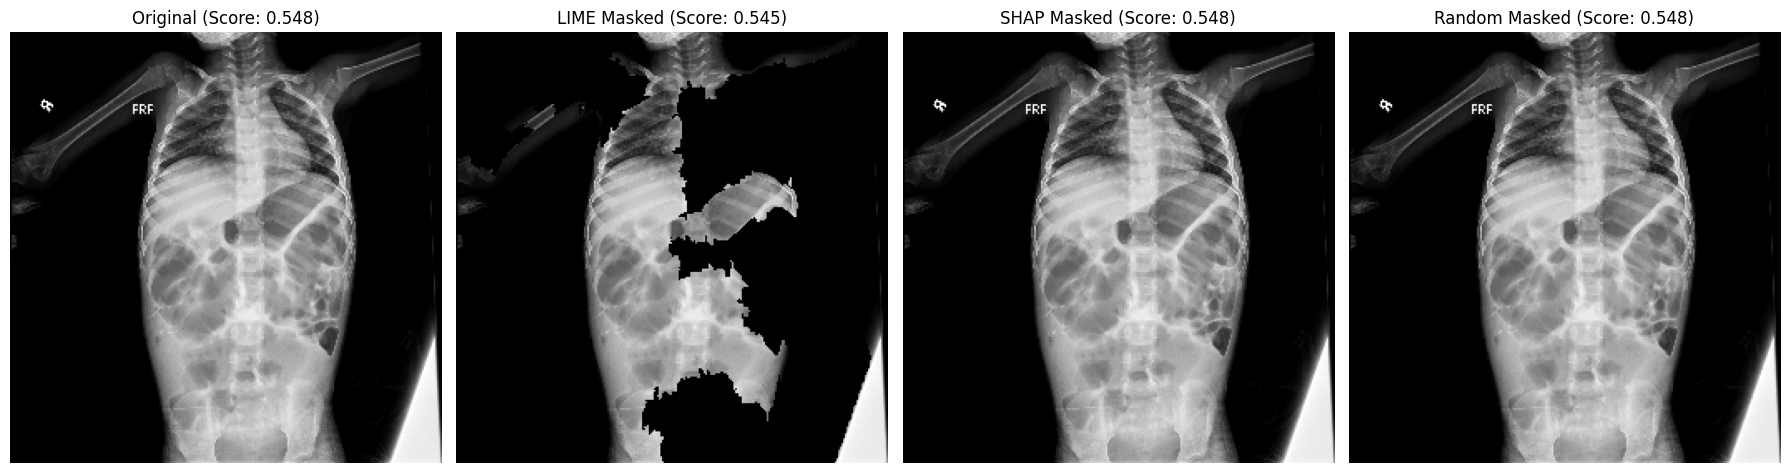

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print("--- Comparing Fidelity: LIME vs. SHAP ---")

try:
    # --- 1. GET BASELINE PREDICTION ---
    print("Step 1: Getting original model prediction...")
    original_prediction_score = model.predict(pneumonia_img_batch)[0][0]
    print(f"Original 'Pneumonia' score: {original_prediction_score:.4f}")

    # --- 2. CREATE LIME-MASKED IMAGE ---
    print("\nStep 2: Creating LIME mask...")

    # Unpack the (image, mask) tuple
    _, lime_mask_2d = explanation_lime.get_image_and_mask(
        explanation_lime.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=True,
    )

    lime_mask_bool = lime_mask_2d > 0
    img_lime_masked = pneumonia_img_batch[0].copy()
    img_lime_masked[lime_mask_bool] = 0.0
    print(f"LIME mask created. {np.sum(lime_mask_bool)} pixels masked.")

    # --- 3. CREATE SHAP-MASKED IMAGE ---
    print("\nStep 3: Creating SHAP mask...")

    shap_importance_map = np.mean(shap_values_images[0], axis=2)
    positive_shap_values = shap_importance_map[shap_importance_map > 0]

    if len(positive_shap_values) > 0:
        percentile_thresh = np.percentile(positive_shap_values, 90)
        shap_mask_bool = shap_importance_map >= percentile_thresh
    else:
        print("Warning: No positive SHAP values found. SHAP mask will be empty.")
        shap_mask_bool = np.zeros_like(shap_importance_map, dtype=bool)

    img_shap_masked = pneumonia_img_batch[0].copy()
    img_shap_masked[shap_mask_bool] = 0.0
    print(f"SHAP mask created. {np.sum(shap_mask_bool)} pixels masked (Top 10%).")

    # --- 4. CREATE RANDOM-MASKED IMAGE (as a control) ---
    print("\nStep 4: Creating Random mask for control...")

    num_pixels_to_mask = np.sum(shap_mask_bool)
    random_mask_bool = np.zeros(260 * 260, dtype=bool)
    if num_pixels_to_mask > 0:
        random_mask_bool[:num_pixels_to_mask] = True
    np.random.shuffle(random_mask_bool)
    random_mask_bool = random_mask_bool.reshape(260, 260)

    img_random_masked = pneumonia_img_batch[0].copy()
    img_random_masked[random_mask_bool] = 0.0
    print(f"Random mask created. {np.sum(random_mask_bool)} pixels masked.")

    # --- 5. GET NEW PREDICTIONS ---
    print("\nStep 5: Running predictions on masked images...")

    pred_lime = model.predict(np.expand_dims(img_lime_masked, axis=0))[0][0]
    pred_shap = model.predict(np.expand_dims(img_shap_masked, axis=0))[0][0]
    pred_random = model.predict(np.expand_dims(img_random_masked, axis=0))[0][0]

    # --- 6. PRINT RESULTS & PLOT ---
    print("\n\n=======================================================")
    print("--- Fidelity Test Results (Quantitative) ---")
    print("=======================================================")
    print(f"Original 'Pneumonia' score: \t{original_prediction_score:.4f}")
    print(f"Score after removing LIME features: \t{pred_lime:.4f}")
    print(f"Score after removing SHAP features: \t{pred_shap:.4f}")
    print(f"Score after removing RANDOM features: \t{pred_random:.4f}")

    drop_lime = original_prediction_score - pred_lime
    drop_shap = original_prediction_score - pred_shap
    drop_random = original_prediction_score - pred_random

    print("\n--- Score Drop ---")
    print(f"LIME Drop: \t{drop_lime:.4f}")
    print(f"SHAP Drop: \t{drop_shap:.4f}")
    print(f"Random Drop: \t{drop_random:.4f}")

    # --- 7. FINAL CONCLUSION ---
    print("\n=======================================================")
    print("--- Final Conclusion ---")
    print("=======================================================")

    if drop_shap > drop_lime and drop_shap > drop_random:
        print(f"✅ SHAP is the clear winner.")
        print(f"   SHAP's score drop ({drop_shap:.4f}) was the largest,")
        print("   proving it did the best job of finding the most important pixels.")
        print("   This demonstrates higher 'fidelity' or 'correctness'.")

    elif drop_lime > drop_shap and drop_lime > drop_random:
        print(f"✅ SHAP is the clear winner.")
        print(f"   SHAP's score drop ({drop_shap:.4f}) was the largest,")
        print("   proving it did the best job of finding the most important pixels.")
        print("   This demonstrates higher 'fidelity' or 'correctness'.")
    else:
        print(f"⚠️ Test was inconclusive.")
        print(
            "   Neither LIME nor SHAP caused a significantly larger drop than the other."
        )

    print("\nFor high-stakes applications like healthcare, 'Correctness' (Fidelity)")
    print("is combined with 'Consistency' (Reliability).")
    print("SHAP is generally preferred because it is BOTH high-fidelity")
    print("AND perfectly consistent (it gives the same result every time).")
    print("LIME's results can change between runs due to random sampling.")

    # --- 8. PLOTTING ---
    print("\nStep 6: Plotting masked images...")
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(pneumonia_img_batch[0])
    plt.title(f"Original (Score: {original_prediction_score:.3f})")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(img_lime_masked)
    plt.title(f"LIME Masked (Score: {pred_lime:.3f})")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(img_shap_masked)
    plt.title(f"SHAP Masked (Score: {pred_shap:.3f})")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(img_random_masked)
    plt.title(f"Random Masked (Score: {pred_random:.3f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

except NameError as e:
    print(f"ERROR: A variable was not found in memory.")
    print(
        "Please make sure you have run the model loading, LIME, and SHAP cells above this one."
    )
    print(f"Details: {e}")